In [1]:
from __future__ import annotations

import glob
import os
import time

from pettingzoo.test import api_test

from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker

from lib.action_mask_wrapper import SB3ActionMaskWrapper
from lib.briscola_env.briscola_env import BriscolaEnv

In [ ]:
PLAYER_COUNT = 4
NUM_TRAINING_STEPS = 1_000_000
NUM_EVAL_GAMES = 500


def make_env():
	return BriscolaEnv(num_players=PLAYER_COUNT)

def make_model(env):
	return MaskablePPO(
        MaskableActorCriticPolicy, 
        env, 
        verbose=1,
        learning_rate=3e-4,
        ent_coef=0.001,
        vf_coef=0.65, 
        normalize_advantage=True
    )

api_test(make_env(), num_cycles=1000)


Starting API test
Passed API test


/home/tim/src/briscola-py/.venv/lib/python3.11/site-packages/pettingzoo/test/api_test.py:242: UserWarning: Observation space for each agent probably should be gymnasium.spaces.box or gymnasium.spaces.discrete
  warnings.warn(
/home/tim/src/briscola-py/.venv/lib/python3.11/site-packages/pettingzoo/test/api_test.py:140: UserWarning: Observation is not a NumPy array
  warnings.warn("Observation is not a NumPy array")
/home/tim/src/briscola-py/.venv/lib/python3.11/site-packages/pettingzoo/test/api_test.py:660: UserWarning: Environment has not defined a render() method
  warnings.warn("Environment has not defined a render() method")


In [3]:
def mask_fn(env):
    return env.action_mask()

def train(
    steps: int = 10_000, seed: int | None = 0, **env_kwargs
):
    # Train a single model to play as each agent in a cooperative Parallel environment
    env = make_env()
    env = SB3ActionMaskWrapper(env)
    env.reset(seed=seed)
    env = ActionMasker(env, mask_fn)

    print(f"Starting training on {str(env.metadata)}.")
    model = make_model(env)
    model.set_random_seed(seed)
    model.learn(total_timesteps=steps)
    model.save(f"{env.unwrapped.metadata.get('name')}_{time.strftime('%Y%m%d-%H%M%S')}")

    print("Model has been saved.")
    print(f"Finished training on {str(env.unwrapped.metadata['name'])}.\n")
    env.close()



In [4]:
train(steps=NUM_TRAINING_STEPS)

Starting training on {'render_modes': []}.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 40       |
|    ep_rew_mean     | 218      |
| time/              |          |
|    fps             | 301      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40          |
|    ep_rew_mean          | 226         |
| time/                   |             |
|    fps                  | 238         |
|    iterations           | 2           |
|    time_elapsed         | 17          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005374495 |
|    clip_fraction        | 0.0139      |
|    clip_range   

In [5]:
# Evaluation Code

def make_results(agents, wins, total_rewards):
    player_results = []
    total_wins = sum(wins.values())
    print("Winrates:")
    for p in agents:
        winrate = wins[p] / total_wins
        print(f"\t{p}: {winrate*100}%")
        print(f"\tWins: {wins[p]} Rewards: {total_rewards[p]}")
        player_results.append({"winrate": winrate, "total_rewards": total_rewards[p]})
    return player_results

def eval_action_mask(player, num_games=100):
    # Evaluate a trained agent vs a random agent
    env = make_env()
    print("Starting evaluation vs random agents.")
    if player != -1:
        print(f"Trained agent will play as {env.possible_agents[player]}")
    try:
        latest_policy = max(
            glob.glob(f"{env.metadata['name']}*.zip"), key=os.path.getctime
        )
    except ValueError:
        print("Policy not found.")
        raise
    print("Using policy:", latest_policy)
    model = MaskablePPO.load(latest_policy)

    wins = {agent: 0 for agent in env.possible_agents}
    total_rewards = {agent: 0 for agent in env.possible_agents}
    for i in range(num_games):
        env.reset(seed=i)
        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()
            observation, action_mask = obs.values()
            if termination or truncation:
                winner = max(env.rewards, key=env.rewards.get)
                wins[winner] += env.infos[winner]["wins"] 
                for a in env.possible_agents:
                    total_rewards[a] += env.rewards[a]
                break
            else:
                # Act randomly unless it's the agents turn
                if player == -1 or agent != env.possible_agents[player]:
                    act = env.action_space(agent).sample(action_mask)
                else:
                    act = int(
                        model.predict(
                            observation, action_masks=action_mask, deterministic=True
                        )[0]
                    )
            env.step(act)
    env.close()
    return make_results(env.agents, wins, total_rewards)


In [6]:
# Run Evaluations
baseline_results = eval_action_mask(-1, num_games=NUM_EVAL_GAMES)
results_by_position = []
for position in range(PLAYER_COUNT):
	results_by_position.append(eval_action_mask(position, num_games=NUM_EVAL_GAMES))

Starting evaluation vs random agents.
Using policy: briscola_20250501-181557.zip
Winrates:
	player_0: 20.8%
	Wins: 104 Rewards: 16071
	player_1: 24.2%
	Wins: 121 Rewards: 19783
	player_2: 19.2%
	Wins: 96 Rewards: 14627
	player_3: 35.8%
	Wins: 179 Rewards: 30771
Starting evaluation vs random agents.
Trained agent will play as player_0
Using policy: briscola_20250501-181557.zip
Winrates:
	player_0: 23.0%
	Wins: 115 Rewards: 18099
	player_1: 24.0%
	Wins: 120 Rewards: 19261
	player_2: 20.0%
	Wins: 100 Rewards: 15062
	player_3: 33.0%
	Wins: 165 Rewards: 28945
Starting evaluation vs random agents.
Trained agent will play as player_1
Using policy: briscola_20250501-181557.zip
Winrates:
	player_0: 20.0%
	Wins: 100 Rewards: 15102
	player_1: 27.400000000000002%
	Wins: 137 Rewards: 22900
	player_2: 19.6%
	Wins: 98 Rewards: 14514
	player_3: 33.0%
	Wins: 165 Rewards: 29165
Starting evaluation vs random agents.
Trained agent will play as player_2
Using policy: briscola_20250501-181557.zip
Winrates:


In [7]:
# Plotting Code
import matplotlib.pyplot as plt
import numpy as np

def make_plot(winrate_data, title):
	winrates = np.transpose(np.array([
		[entry['winrate'] for entry in sublist] 
		for sublist in winrate_data
   	]))
	fig, ax = plt.subplots(figsize=(8, 6))

	# How many groups and bars
	num_positions, num_players = winrates.shape
	x = np.arange(num_players)

	# Width of each bar group
	bar_width = 0.2
	
	# Plot each group's bars
	for i in range(num_positions):
		ax.bar(x + i * bar_width, winrates[i], width=bar_width, label=f'Player {i}')

	# Labels and stuff
	ax.set_xlabel('Model Position')
	ax.set_ylabel('Winrate')
	ax.set_title(title)
	ax.set_xticks(x + bar_width * (num_positions-1) / 2)
	ax.set_xticklabels([str(i) for i in range(num_players)])
	ax.legend()

	plt.tight_layout()
	plt.show()
	plt.close(fig)


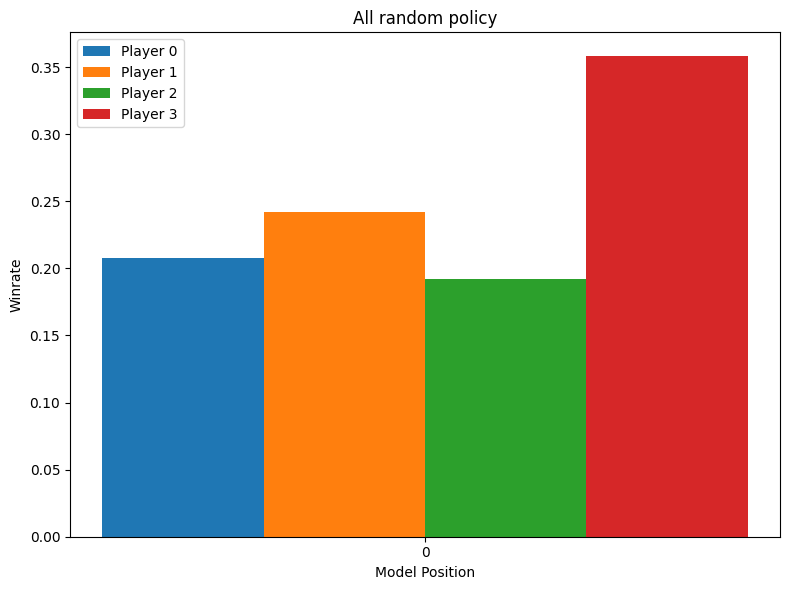

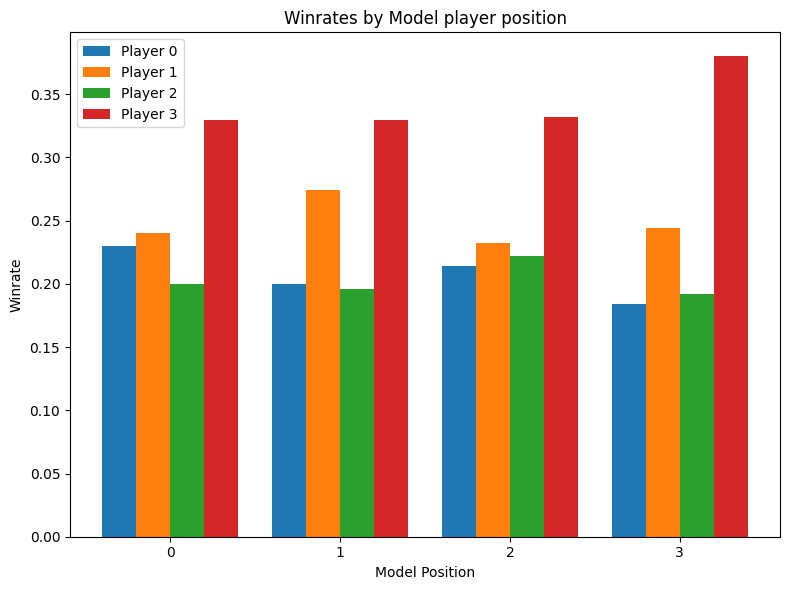

In [8]:
# Generate diagrams
make_plot([baseline_results], "All random policy")
make_plot(results_by_position, "Winrates by Model player position")